In [2]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from scipy import optimize
from scipy import integrate
from scipy.integrate import simpson
from scipy.integrate import quad
from pathlib import Path
from os import listdir, chdir
from os.path import isfile, join
import regex as re
from lmfit import Model
from lmfit.models import LinearModel, GaussianModel, ExponentialModel, ConstantModel, PowerLawModel, PolynomialModel, LorentzianModel
import math
import time

In [3]:
def get_xy_motor(sample_name, data_path):
    try:
        # Find the x_motor position in the file title using Regex
        start_x = re.search('_x_', sample_name).end()
        end_x = re.search('mm_primary', sample_name).start() 
        x_motor = sample_name[start_x:end_x].replace(',', '.')
        x_motor = float(x_motor)
        
        # Find the y_motor position in the file title using Regex
        start_y = re.search('_y_', sample_name).end()
        end_y = re.search('mm_sample_x', sample_name).start()
        y_motor = sample_name[start_y:end_y].replace(',', '.')
        y_motor = float(y_motor)
    
    except AttributeError:
        print('oh shit bra, the name changed! (function could not find x and y position in file name)')
        x_motor = input('Whats the x value?')
        x_motor = float(x_motor)
        
        y_motor = input('Whats the y value?')
        y_motor = float(y_motor)
        print("Groovie.")
    
    return x_motor, y_motor


In [4]:
def make_file_list(data_path):
    
    list_of_files = [files for files in listdir(data_path) if isfile(join(data_path, files))]

    new_list = list(filter(lambda file: True if 'mean_q' in file else False, list_of_files))

            
            
    # #get the cords of the first file
    # start_x, start_y = get_xy_motor(list_of_files[0], data_path)
    # #end_index = -99999
    # for i in range(len(list_of_files)): 
    #     x_motor, y_motor = get_xy_motor(list_of_files[i], data_path)
    #     #if (str(x_motor) == str(start_x)):
    #         #if (str(y_motor) == str(start_y)):
    #             #end_index = i
    #             #break
    
    return new_list

In [5]:
def xy_coords(rel_files, data_path):
    x_coords = []
    y_coords = []
    for file in rel_files:
        x_motor, y_motor = get_xy_motor(file, data_path)
        x_coords.append(x_motor)
        y_coords.append(y_motor)
    x_coords = list(set(x_coords))
    y_coords = list(set(y_coords))
    
    return x_coords, y_coords

In [6]:
def whats_the_point(x, y):
    current_point_list = []
    for file in rel_files:
        x_motor, y_motor = get_xy_motor(file, data_path)
        if ((x_motor == list(x_coords)[x]) and (y_motor == list(y_coords)[y])):
            current_point_list.append(file)
    return current_point_list

In [7]:
def get_time(file):
#      start_x = re.search('_x_', sample_name).end()
#         end_x = re.search('mm_primary', sample_name).start() 
#         x_motor = sample_name[start_x:end_x].replace(',', '.')
    start = re.search('_2023', file).end() + 5
    end = start + 6
    start = int(start)
    end = int(end)
    
    return(file[start: end])
    

In [8]:
def get_xrd_data(current_point_list):
    df_list = []
    for file in current_point_list:
        #INPUT - Set the path to the output files from the I vs q script - Use absolute path
        os.chdir(data_path)

        # Importing integrated XRD pattern from NSLS-II Summer 2022
        time = get_time(file)
        file = open(file)
        data = pd.read_csv(file, skiprows = 1, header = None, delim_whitespace=True)
        df = pd.DataFrame(data)
        df.columns = ['q','I']
        df['time'] = time
        df_list.append(df)
    return df_list

In [9]:
def get_min(df_list):
    my_min = -10
    for df in df_list:
        if df['I'].min() > my_min:
            my_min = df['I'].min()
    return my_min

In [10]:
def make_pretty_figure(df_list, my_min, y_coord, x_coord, print_every_m, scale):

        #sorted(student_objects, key=lambda student: student.age)
    df_list = sorted(df_list, key = lambda df: df['time'].unique())
    bounds  = [int(df['time'].unique()) for df in df_list]
    print(type(bounds))
    
    plt.figure()
    n = len(df_list)
    #color = iter(cm.viridis(np.linspace(0, 1, n)))
   
    # colormap
    cmap = plt.get_cmap('viridis', n)
   
    for i in range(len(df_list)):
        df = df_list[i]
        q_min = 1.6
        q_max = 1.95
        #q_min = 2.5
        #q_max = 2.55
        df = df[(df['q'] >= q_min) & (df['q'] <= q_max)]
        local_min = df['I'].min()
        dif = local_min - my_min

        x = df['q']
       # y = df['I'].add(-dif + (n * 5) - (i * 5) + 5)
        y = df['I'].add(-dif + (n * scale) + (i * scale) + 5)
        if abs(y.max())-abs(y.min()) > 2:
            if i % print_every_m == 0:
                #c = next(color)
                #plt.plot(x,y, label = str(i) + ' min', color = c)
                plt.plot(x,y, label = str(i) + ' min', c = cmap(i))

    #plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('q (1/A)')
    plt.ylabel('Intenisty (a.u.)')
    plt.title('Graphite 6C charge: (' + str(x_coord) + ',' + str(y_coord) + ')', fontsize = 15)

    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    ticks = np.linspace(0,n, n+1)
   # plt.colorbar(sm, ticks=ticks, label = 'time (min)', boundaries = [1, 13])
    plt.colorbar(sm, ticks=ticks, label = 'time (min)')
    plt.show()

In [11]:
def make_graphs(y_coords, x_coords, print_every_m, scale):
    for i in range(len(y_coords)):
        for j in range(len(x_coords)):
            current_point_list = whats_the_point(j, i)
            df_list = get_xrd_data(current_point_list)
            my_min =get_min(df_list)
            make_pretty_figure(df_list, my_min, y_coords[i], x_coords[j], print_every_m, scale)

<class 'list'>


C:\Users\Elizabeth Allan-Cole\AppData\Local\Temp\ipykernel_11856\3919324769.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=ticks, label = 'time (min)')


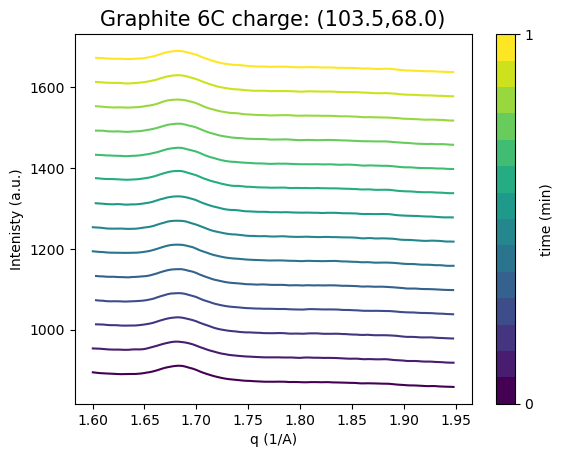

<class 'list'>


C:\Users\Elizabeth Allan-Cole\AppData\Local\Temp\ipykernel_11856\3919324769.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=ticks, label = 'time (min)')


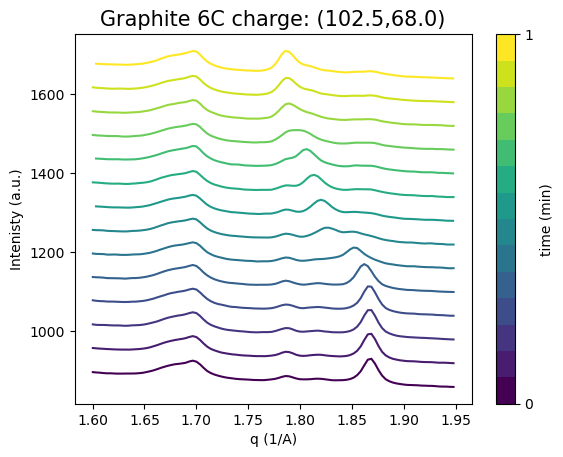

<class 'list'>


C:\Users\Elizabeth Allan-Cole\AppData\Local\Temp\ipykernel_11856\3919324769.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=ticks, label = 'time (min)')


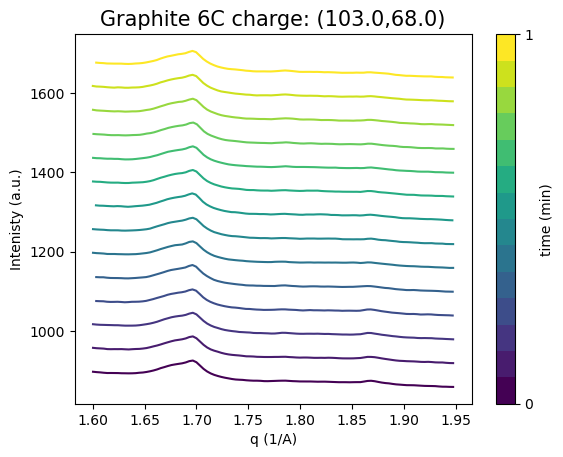

In [18]:
# Sample info
sample_name = 'S1_LN_10psi_Ch10_0120922_operando_charge_01'
peak_name = 'graphite_LixC6'
print_every_m = 1
scale= 60
#scale= 0.25
# Set path to correct (where the I vs q data is)
data_path_gen = r'D:\NSLS-II Winter 2023'
data_path = data_path_gen + '\\' + sample_name + '\\integration'
os.chdir(data_path)

rel_files = make_file_list(data_path)
x_coords, y_coords = xy_coords(rel_files, data_path)
make_graphs (y_coords, x_coords, print_every_m, scale)

<class 'list'>


C:\Users\Elizabeth Allan-Cole\AppData\Local\Temp\ipykernel_11856\3919324769.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=ticks, label = 'time (min)')


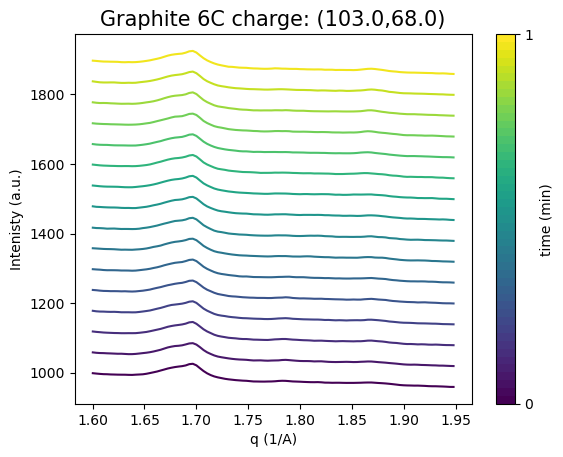

<class 'list'>


C:\Users\Elizabeth Allan-Cole\AppData\Local\Temp\ipykernel_11856\3919324769.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=ticks, label = 'time (min)')


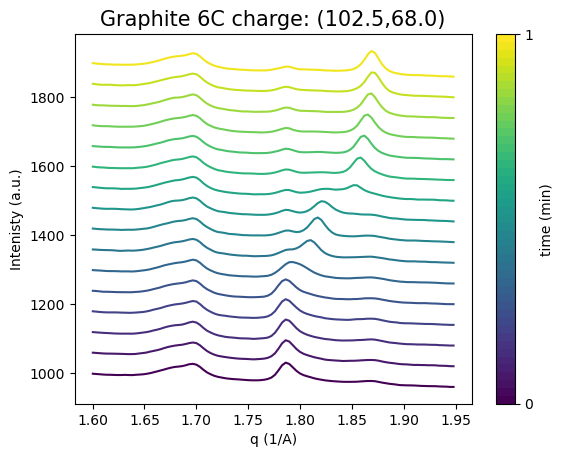

<class 'list'>


C:\Users\Elizabeth Allan-Cole\AppData\Local\Temp\ipykernel_11856\3919324769.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=ticks, label = 'time (min)')


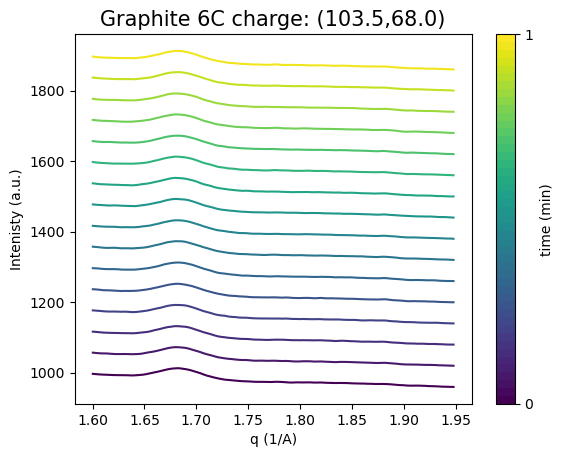

In [20]:
# Sample info
sample_name = 'S1_LN_10psi_Ch10_0120922_operando_discharge_02'
peak_name = 'graphite_LixC6'
print_every_m = 3
scale = 20
#scale = 0.5
# Set path to correct (where the I vs q data is)
data_path_gen = r'D:\NSLS-II Winter 2023'
data_path = data_path_gen + '\\' + sample_name + '\\integration'
os.chdir(data_path)

rel_files = make_file_list(data_path)
#print(rel_files)
x_coords, y_coords = xy_coords(rel_files, data_path)
make_graphs (y_coords, x_coords, print_every_m, scale)